In [137]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/PTKD/HPG.csv')
df=df.reset_index()['Price']
df

0       14832
1       15284
2       15561
3       15410
4       15234
        ...  
1246    21350
1247    21200
1248    21400
1249    21600
1250    21650
Name: Price, Length: 1251, dtype: int64

In [140]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [141]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [142]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [143]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [144]:
import xgboost as xgb

# 8. Define GRU Model
model = xgb.XGBRegressor(
             colsample_bynode=1, colsample_bytree=1, gamma=0.01,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42)

In [145]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
             grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=400, n_jobs=1,
             nthread=None, num_parallel_tree=None, predictor=None, ...)

In [146]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

In [147]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred.reshape(-1,1))
y_pred_val=scaler.inverse_transform(y_pred_val.reshape(-1,1))

In [148]:
train_size1 = int(0.8 * len(df))
test_size1 = int(0.1 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

# re make predictions on the testing set
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

# re make predictions on the validate set
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [149]:
# 11. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 1705.7975108067592
Testing RMSE: 4538.697439407234
Validation MAPE: 6.707101391457564
Testing MAPE: 19.48483809083394
Validation MAE: 1312.2889657738094
Testing MAE: 3865.2739599609376


In [150]:
#Dự đoán 30 ngày tiếp theo
pred_next = np.array([])

y_val_to_next=scaler.fit_transform(np.array(y_val1[-time_step:].reshape(1,-1).reshape(1,time_step)).reshape(-1,1))

for i in range(30):
    print(y_val_to_next)
    y_pred_next = model.predict(y_val_to_next.reshape(1,-1))
    y_val_to_next = np.append(y_val_to_next,y_pred_next[0])[1:]
    pred_next = np.append(pred_next,y_pred_next[0])

next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)))

[[0.13559322]
 [0.        ]
 [0.06779661]
 [0.13559322]
 [0.27118644]
 [0.22033898]
 [0.18644068]
 [0.28813559]
 [0.76271186]
 [0.77966102]
 [0.59322034]
 [0.71186441]
 [0.79661017]
 [0.91525424]
 [0.57627119]
 [0.6440678 ]
 [0.57627119]
 [0.59322034]
 [0.11864407]
 [0.49152542]
 [0.40677966]
 [0.37288136]
 [0.27118644]
 [0.40677966]
 [0.47457627]
 [0.6440678 ]
 [0.54237288]
 [0.84745763]
 [0.74576271]
 [0.61016949]
 [0.71186441]
 [0.47457627]
 [0.23728814]
 [0.20338983]
 [0.50847458]
 [0.40677966]
 [0.3220339 ]
 [0.33898305]
 [0.57627119]
 [0.61016949]
 [0.61016949]
 [0.6440678 ]
 [0.57627119]
 [0.30508475]
 [0.6440678 ]
 [0.49152542]
 [0.33898305]
 [0.20338983]
 [0.3559322 ]
 [0.30508475]
 [0.33898305]
 [0.33898305]
 [0.47457627]
 [0.44067797]
 [0.47457627]
 [0.47457627]
 [0.47457627]
 [0.54237288]
 [0.57627119]
 [0.71186441]
 [0.71186441]
 [0.61016949]
 [0.44067797]
 [0.47457627]
 [0.45762712]
 [0.3559322 ]
 [0.42372881]
 [0.49152542]
 [0.52542373]
 [0.47457627]
 [0.47457627]
 [0.44

In [151]:
next30days_predict_inverse

,0
0,21603.470764
1,21575.959471
2,21542.516077
3,21583.441898
4,21560.681632
5,21560.681632
6,21560.681632
7,21570.512670
8,21583.441898
9,21570.512670


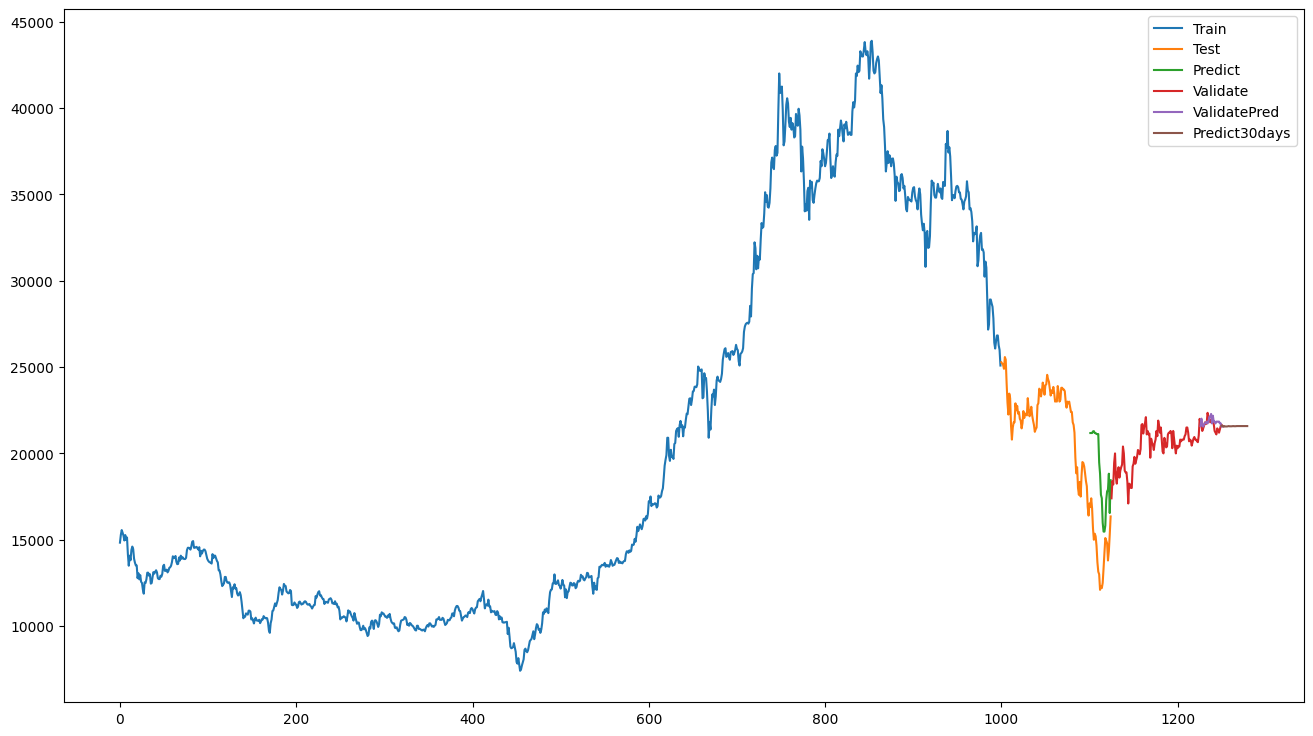

In [152]:
# 14.Vẽ hình
plt.figure(figsize =(16, 9))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,train_data1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_data1)
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,val_data1)
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,next30days_predict_inverse)
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [153]:
train_data

array([[0.20337682],
       [0.21576582],
       [0.22335818],
       [0.21921938],
       [0.21439535],
       [0.20680298],
       [0.21549172],
       [0.20778972],
       [0.21162701],
       [0.18462888],
       [0.16678544],
       [0.18271023],
       [0.17547418],
       [0.19186493],
       [0.19715492],
       [0.19331762],
       [0.1778862 ],
       [0.17160947],
       [0.1672514 ],
       [0.1672514 ],
       [0.14699594],
       [0.15472536],
       [0.14507729],
       [0.15181998],
       [0.14121259],
       [0.13929394],
       [0.12868655],
       [0.12240982],
       [0.14025326],
       [0.13929394],
       [0.14507729],
       [0.15568468],
       [0.15568468],
       [0.15086065],
       [0.15327267],
       [0.13833461],
       [0.13929394],
       [0.148942  ],
       [0.15664401],
       [0.15423199],
       [0.15713738],
       [0.15954939],
       [0.15617805],
       [0.14699594],
       [0.14557066],
       [0.14557066],
       [0.15086065],
       [0.149